# Intro to neural nets with fastai
> Understanding building block of fastai and pytorch.

- toc: true 
- badges: true
- comments: true
- author: Martynas Lozys
- image: images/diagram.png
- categories: [fastai, pytorch, neural net, beginner, mnist]

# MNIST fastai walkthrough

The aim of this notebook is to go through and understand steps in https://github.com/fastai/fastbook/blob/master/04_mnist_basics.ipynb. 
In particular, how MNIST images are classified starting from getting data and ending with neural net parameter optimization.
In most cases I will try to take existing fastai implementation and distil it to constituent parts using basic PyTorch operations.

# Imports

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from IPython.core.display import display, HTML
import math
import matplotlib.pyplot as plt
import functools
import pylab

from fastai.datasets import untar_data, URLs
from fastai.vision.image import *
from fastai.metrics import accuracy

import torch
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import tensor
from torch.optim import SGD

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

pylab.rcParams['figure.figsize'] = (15, 8)
pylab.rcParams['font.size'] = 10
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Inspect data

Get data from pre-stored link in one of fastai modules and inspect the content

In [3]:
URLs.MNIST

'https://s3.amazonaws.com/fast-ai-imageclas/mnist_png'

In [4]:
data_path = untar_data(URLs.MNIST)
data_path

PosixPath('/root/.fastai/data/mnist_png')

Dataset is already split into testing and training

In [5]:
data_path.ls()

[PosixPath('/root/.fastai/data/mnist_png/testing'),
 PosixPath('/root/.fastai/data/mnist_png/training')]

Each has separate folders for target classes 0 - 9

In [6]:
Path.joinpath(data_path, 'testing').ls()

[PosixPath('/root/.fastai/data/mnist_png/testing/5'),
 PosixPath('/root/.fastai/data/mnist_png/testing/6'),
 PosixPath('/root/.fastai/data/mnist_png/testing/4'),
 PosixPath('/root/.fastai/data/mnist_png/testing/1'),
 PosixPath('/root/.fastai/data/mnist_png/testing/9'),
 PosixPath('/root/.fastai/data/mnist_png/testing/7'),
 PosixPath('/root/.fastai/data/mnist_png/testing/3'),
 PosixPath('/root/.fastai/data/mnist_png/testing/2'),
 PosixPath('/root/.fastai/data/mnist_png/testing/8'),
 PosixPath('/root/.fastai/data/mnist_png/testing/0')]

See number of images in each, around 80/20% split

In [7]:
[f"Number of images in training set {len(Path.joinpath(data_path, 'training', str(label)).ls())}, "
 f"test set {len(Path.joinpath(data_path, 'testing', str(label)).ls())}"
 for label in range(10)]

['Number of images in training set 5923, test set 980',
 'Number of images in training set 6742, test set 1135',
 'Number of images in training set 5958, test set 1032',
 'Number of images in training set 6131, test set 1010',
 'Number of images in training set 5842, test set 982',
 'Number of images in training set 5421, test set 892',
 'Number of images in training set 5918, test set 958',
 'Number of images in training set 6265, test set 1028',
 'Number of images in training set 5851, test set 974',
 'Number of images in training set 5949, test set 1009']

Each image has identifier in its filename

In [8]:
Path.joinpath(data_path, 'training', '0').ls()[:10]

[PosixPath('/root/.fastai/data/mnist_png/training/0/15559.png'),
 PosixPath('/root/.fastai/data/mnist_png/training/0/55745.png'),
 PosixPath('/root/.fastai/data/mnist_png/training/0/4340.png'),
 PosixPath('/root/.fastai/data/mnist_png/training/0/26073.png'),
 PosixPath('/root/.fastai/data/mnist_png/training/0/20548.png'),
 PosixPath('/root/.fastai/data/mnist_png/training/0/19492.png'),
 PosixPath('/root/.fastai/data/mnist_png/training/0/31470.png'),
 PosixPath('/root/.fastai/data/mnist_png/training/0/8323.png'),
 PosixPath('/root/.fastai/data/mnist_png/training/0/19009.png'),
 PosixPath('/root/.fastai/data/mnist_png/training/0/11409.png')]

Images are of size 28 x 28 pixels, monochrome

In [9]:
im = PIL.Image.open('/root/.fastai/data/mnist_png/training/0/15559.png')
print(im.size)
im

(28, 28)


# From images to tensors

Load image from previous section to tensor, check it's type and dimensions

In [10]:
im_tensor = transforms.ToTensor()(im)
type(im_tensor), im_tensor.shape

(torch.Tensor, torch.Size([1, 28, 28]))

Load few images from a single class into tensor. Note that there's one extra dimension, so we need to reshape into rank 2 before stacking

In [11]:
zeroes_path = Path.joinpath(data_path, 'training', '0').ls()[:10]
zeroes = torch.stack([transforms.ToTensor()(PIL.Image.open(image_path)).reshape((28, 28))
                      for image_path in zeroes_path])

Now this tensor contains first 10 images from zeroes category

torch.Size([10, 28, 28])


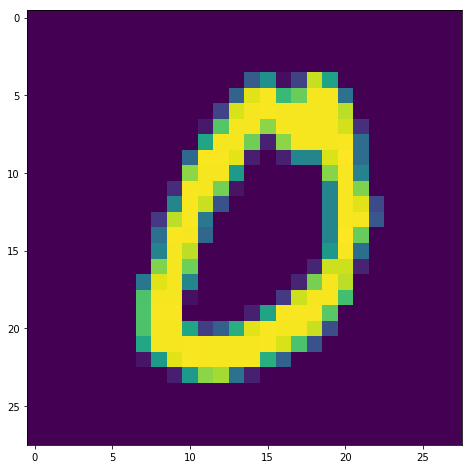

In [12]:
print(zeroes.shape)
plt.imshow(zeroes[0])

Now concatenate tensors loaded from couple categories

In [13]:
class_paths = [Path.joinpath(data_path, 'training', '0'), 
               Path.joinpath(data_path, 'training', '1')]
NUM_SAMPLES = 10


zeroes_and_ones = torch.cat([
    torch.stack([transforms.ToTensor()(PIL.Image.open(image_path)).reshape((28, 28))
                 for image_path in class_path.ls()[:NUM_SAMPLES]])
    for class_path in class_paths
])

Small utitlity to show few images at once

In [14]:
import math
def show_images(ims, nrows=1, ncols=None):
    if ncols is None: ncols = int(math.ceil(len(ims) / nrows))
    axs = plt.subplots(nrows, ncols)[1].flat
    for im, ax in zip(ims, axs): ax.imshow(im)

Now we have images from both classes loaded in a single tensor

torch.Size([20, 28, 28])


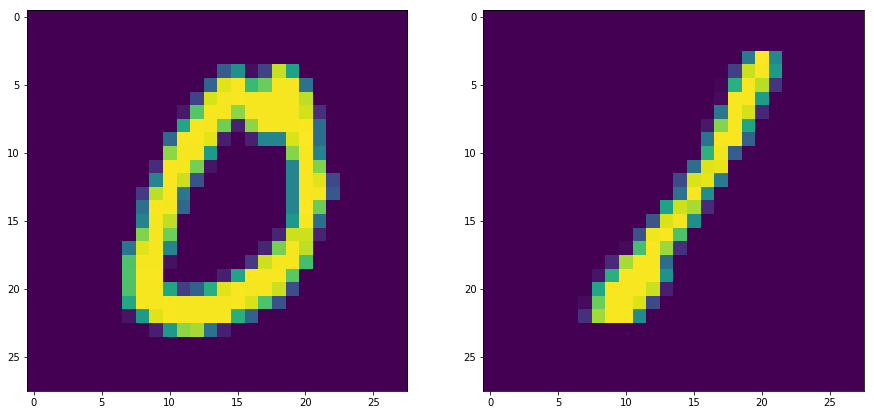

In [15]:
print(zeroes_and_ones.shape)
show_images((zeroes_and_ones[0], zeroes_and_ones[-1]))

Input look already scaled, so don't need to take extra preprocessing steps

In [16]:
zeroes_and_ones.min(), zeroes_and_ones.max() 

(tensor(0.), tensor(1.))

Reshape images into vectors, such that each image is a row / observation, that's our prepared x data

In [17]:
x = zeroes_and_ones.view(-1, 28 * 28)
x.shape

torch.Size([20, 784])

## Load labels to tensor

Extract labels from image folder path and get number of images in each

In [18]:
labels_sizes = [(int(str(path).split('/')[-1]), len(path.ls()))
                for path in class_paths]
labels_sizes

[(0, 5923), (1, 6742)]

Repeat each label number of times specified by number of items in class

In [19]:
y = tensor([label for label_size in labels_sizes 
            for label in [label_size[0]] * label_size[1]])
print(f'Target shape as expected: {y.shape[0] == labels_sizes[0][1] + labels_sizes[1][1]}')
y

Target shape as expected: True


tensor([0, 0, 0,  ..., 1, 1, 1])

# Customized Image Dataset

Based on findings above, let's create a single class performing all these steps and returning features (X) and targets (y) as tensors.

In [20]:
class ImageDataSet:
    
    def __init__(self, data_path, image_size=(28, 28), num_samples=None):
        self.data_path = data_path
        self.image_size = image_size
        self.num_samples = num_samples
        
    def load_class_images_to_tensor_list(self, class_path):
        return torch.stack([transforms.ToTensor()(PIL.Image.open(image_path)).reshape(self.image_size) 
                            for image_path in class_path.ls()[:self.num_samples]]).float()
    
    def stack_class_tensors(self):
        return torch.cat([
            self.load_class_images_to_tensor_list(class_path)
            for class_path in sorted(self.data_path.ls())
        ])
    
    @staticmethod
    def tensor_to_vector(t):
        return t.view(-1, t.shape[-1] * t.shape[-2])
    
    @property
    def x(self):
        stacked_tensor = self.stack_class_tensors()
        return self.tensor_to_vector(stacked_tensor)
    
    @property
    def y(self):
        labels_sizes = [
            (self._extract_label_from_path(path), len(path.ls()[:self.num_samples]))
            for path in sorted(self.data_path.ls())
        ]
        return tensor([label for label_size in labels_sizes 
                       for label in [label_size[0]] * label_size[1]])

    @staticmethod
    def _extract_label_from_path(path):
        return int(str(path).split('/')[-1])

Use this class to create training and validation sets with 100 samples each

In [21]:
ds = ImageDataSet(data_path=Path.joinpath(data_path, 'training'), num_samples=100)
train_x, train_y = ds.x, ds.y

ds_val = ImageDataSet(Path.joinpath(data_path, 'testing'), num_samples=100)
valid_x, valid_y = ds_val.x, ds_val.y

Shapes and images look as expected

torch.Size([1000, 784]) torch.Size([1000])
tensor(0) tensor(9)


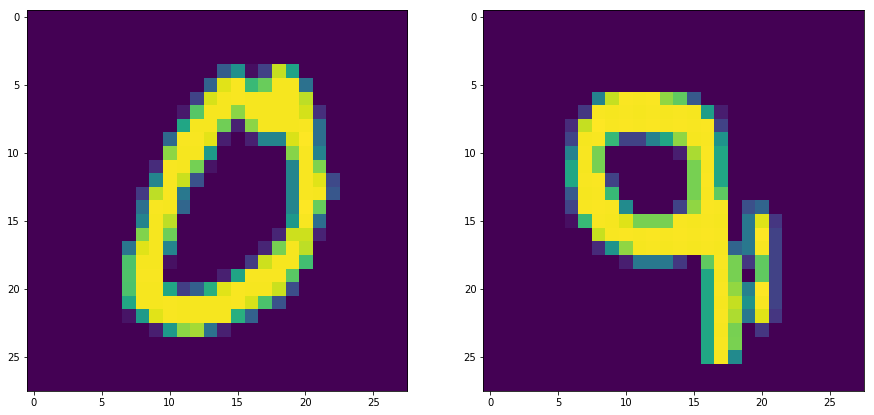

In [22]:
print(train_x.shape, train_y.shape)
print(train_y[0], train_y[-1])
show_images((train_x[0].view(28, 28), train_x[-1].view(28, 28)))

Zip x and y into single data structures

In [23]:
dset = list(zip(train_x, train_y))
valid_dset = list(zip(valid_x, valid_y))

Check again that everything is correct

tensor(0) tensor(9)


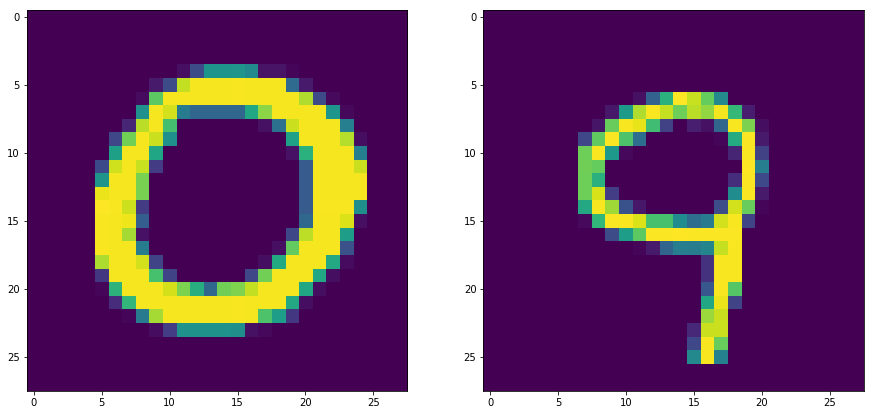

In [24]:
x1, y1 = valid_dset[0]
x2, y2 = valid_dset[-1]
print(y1, y2)
show_images((x1.view(28, 28), x2.view(28, 28)))

# Custom Data Loader

Now let's pass these created datasets to training and validation data loaders that randomize image order and allow us to stream inputs in batches for stochastic gradient descent

In [25]:
import random

class DataLoader_:
    
    def __init__(self, dset, batch_size):
        self.chunked_dset = self.chunker(dset, batch_size)
        
    def chunker(self, dset, batch_size):
        random.shuffle(dset)
        return (dset[idx:idx + batch_size] 
                for idx in range(0, len(dset), batch_size))
    
    def __iter__(self):
        return self
    
    def __next__(self):
        try:
            x_b, y_b = list(zip(*next(self.chunked_dset)))
            return torch.stack(x_b), torch.stack(y_b)
        except IndexError:
            raise StopIteration()

In [26]:
dl = DataLoader_(dset, batch_size=256)

In [27]:
x_b, y_b = next(dl)
x_b.shape, y_b.shape

(torch.Size([256, 784]), torch.Size([256]))

Looks like our custom data loader is working fine so far!

(<matplotlib.image.AxesImage at 0x7f4dc1de24e0>, tensor(0))

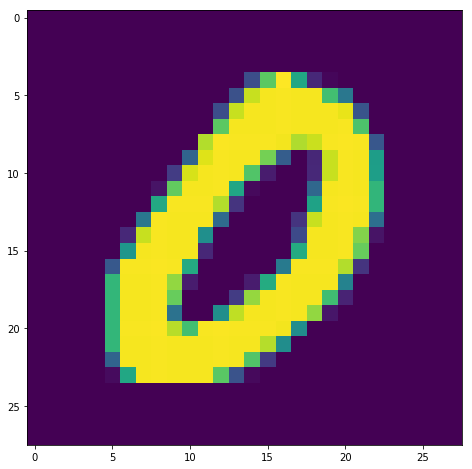

In [28]:
plt.imshow(x_b[0].view(28, 28)), y_b[0]

# Custom learner

Let's build a learner that is initialized by passing:
 - dataloader with batch size
 - neural net
 - optimizer
 - loss function
 - metric
 
Then trains and validates the model for a specified number of epochs in the following manner:
 - get batch of data from training data loader
 - perform forward pass through the network
 - calculate loss and it's gradients
 - update weights via backpropagation using optimizer
 - get batch from validation data loader
 - perform forward pass through the network
 - calculate and print performance metric

In [29]:
class CustomLearner:
    
    def __init__(self, dsets, batch_size, model, optimizer, loss_fn, metric):
        self.train_dset, self.valid_dset = dsets
        self.batch_size = batch_size
        self.model = model
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.metric = metric
        
    def train_model(self, num_epochs):
        for epoch in range(num_epochs):
            self.train_epoch()
            print(self.validate_epoch())
            
    def train_epoch(self):
        train_dl = DataLoader_(self.train_dset, self.batch_size)
        for x_batch, y_batch in train_dl:
            self.calculate_gradient(x_batch, y_batch)
            self.optimizer.step()
            self.optimizer.zero_grad()

    def calculate_gradient(self, x_batch, y_batch):
        predictions = self.model.forward(x_batch)
        self.loss_fn(predictions, y_batch).backward()
        
    def validate_epoch(self):
        valid_dl = DataLoader_(self.valid_dset, self.batch_size)
        metrics = [self.metric(self.model.forward(x_batch), y_batch) 
                   for x_batch, y_batch in valid_dl]
        return torch.stack(metrics).mean().item()

Setting constants that will be used for later customizations. Number of epochs, learning rate, number of activations are set to achieve fast iteration time, in real life more time should be spent finding the right values.

In [30]:
BATCH_SIZE = 256
LEARNING_RATE = .1
NUM_CLASSES = 10
NUM_EPOCHS = 20
NUM_ACTIVATIONS = 30
INPUT_SIZE = np.prod(ds.image_size)
dsets = dset, valid_dset

Set up simple neural net with two hidden linear layers and ReLU non-linearity inbetween. SGD optimizer is imported from Torch.

In [31]:
simple_net = nn.Sequential(
    nn.Linear(INPUT_SIZE, NUM_ACTIVATIONS),
    nn.ReLU(),
    nn.Linear(NUM_ACTIVATIONS, NUM_CLASSES)
)

optimizer = SGD(simple_net.parameters(), lr=LEARNING_RATE)

Could get close to 90% accuracy, if ran for more epochs, even with 100 samples of each category

In [32]:
CustomLearner(dsets=dsets, model=simple_net, optimizer=optimizer, 
              loss_fn=nn.functional.cross_entropy, metric=accuracy, batch_size=BATCH_SIZE).train_model(NUM_EPOCHS)

0.2705078125
0.37961339950561523
0.38820043206214905
0.39874058961868286
0.4237270951271057
0.515625
0.6041218042373657
0.6594154238700867
0.7188173532485962
0.7535358667373657
0.7850888967514038
0.7883216738700867
0.8005118370056152
0.8135439157485962
0.8139142990112305
0.8240840435028076
0.8288658261299133
0.8256330490112305
0.8353986740112305
0.8409886956214905


# Custom Neural Net

Reconstruct same neural net used above from scratch (using matrix algebra instead of nn module)

In [33]:
from torch.nn.parameter import Parameter  # Still need to import this to simplify weight optimization

class SimpleNet(nn.Module):
    
    def __init__(self, input_size, num_activations, output_size):
        super().__init__()
        self.weights_1, self.bias_1 = (self.init_params((input_size, num_activations)), 
                                       self.init_params(num_activations))
        self.weights_2, self.bias_2 = (self.init_params((num_activations, output_size)),
                                       self.init_params(output_size))
    
    @staticmethod
    def init_params(size):
        return Parameter(torch.randn(size))
    
    @staticmethod
    def linear(x_batch, weight, bias):
        return x_batch.matmul(weight) + bias
    
    @staticmethod
    def relu(x_batch):
        return x_batch.max(tensor(.0))
    
    def forward(self, x_batch):
        res = self.linear(x_batch, self.weights_1, self.bias_1)
        res = self.relu(res)
        return self.linear(res, self.weights_2, self.bias_2)

For some reason results are not the same as with torch implementation but loss is improving, so let's leave it for now.

In [34]:
sn = SimpleNet(INPUT_SIZE, NUM_ACTIVATIONS, NUM_CLASSES)
optimizer = SGD(sn.parameters(), lr=LEARNING_RATE)
CustomLearner(dsets=dsets, model=sn, optimizer=optimizer, 
              loss_fn=nn.functional.cross_entropy, metric=accuracy, batch_size=BATCH_SIZE).train_model(NUM_EPOCHS)

0.2481479048728943
0.30222925543785095
0.3339506983757019
0.3820379972457886
0.4140961766242981
0.4288456439971924
0.45251885056495667
0.4697939157485962
0.4874057173728943
0.5145474076271057
0.5266702771186829
0.5344827771186829
0.5311826467514038
0.5461341738700867
0.553104817867279
0.5487607717514038
0.5586274266242981
0.5698074102401733
0.5704808831214905
0.575835108757019


# Custom optimizer

Now let's replace torch SGD with our own, that updates weights by multiplying their respective gradients by the learning rate and resets gradients afterwards for the next batch.

In [35]:
class CustomSGD:
    
    def __init__(self, params, learning_rate):
        self.params = list(params)
        self.learning_rate = learning_rate
        
    def step(self):
        for p in self.params:
            p.data -= p.grad.data * self.learning_rate
            
    def zero_grad(self):
        for p in self.params:
            p.grad = None

Results look similar

In [36]:
sn = SimpleNet(INPUT_SIZE, NUM_ACTIVATIONS, NUM_CLASSES)
optimizer = CustomSGD(sn.parameters(), LEARNING_RATE)
CustomLearner(dsets=dsets, model=sn, optimizer=optimizer, 
              loss_fn=nn.functional.cross_entropy, metric=accuracy, batch_size=BATCH_SIZE).train_model(NUM_EPOCHS)

0.18989089131355286
0.2645474076271057
0.32869747281074524
0.37624597549438477
0.4138941168785095
0.4393520951271057
0.46656113862991333
0.47875136137008667
0.4880791902542114
0.5011449456214905
0.5049164891242981
0.5155239701271057
0.5196322798728943
0.5225619673728943
0.5179822444915771
0.5334051847457886
0.5425310134887695
0.5500741004943848
0.5528690814971924
0.5544517636299133


# Custom loss function

Now let's replace torch's cross entropy loss. Which essentially applies log-softmax to each row of last activation layer output (recall this output has n_input * n_classes shape) and picks value that corresponds to target class index and takes the negative mean of them. Also note that softmax = exponentiated element of a row divided by the sum of all exponentiated row elements.

Let's take one batch and pass it through our already trained network to illustrate this

In [37]:
x_b, y_b = next(dl)

In [38]:
preds = sn.forward(x_b)
print(preds.shape)
preds

torch.Size([256, 10])


tensor([[ -9.6009,  -2.2568,  -5.2367,  ...,   3.7184,  -5.2098,   3.2839],
        [ -5.9776,   0.3611,  -0.2300,  ...,   2.1829,   2.4964,   1.5622],
        [ -9.5683,  -4.8592,   0.0759,  ...,  -4.8130,   1.6519,  -2.8534],
        ...,
        [ -6.4912,  16.1188,   4.1472,  ...,   4.3423,  -6.6100,   5.7818],
        [ -6.3775,   9.4231,   3.0040,  ...,   1.6132,  -4.2952,   1.6586],
        [ -0.6388,  10.0356,   5.0243,  ...,   8.9645, -18.8030,   2.5508]],
       grad_fn=<AddBackward0>)

In [39]:
def _log_softmax(input, dim):
    return input.exp().div(input.exp().sum(dim).unsqueeze(1)).log()

In [40]:
def cross_entropy_loss(preds, target):
    return -_log_softmax(preds, 1).gather(1, target.unsqueeze(1)).mean()

Differences in log_softmax implementation are small, but for some reason using custom softmax does not update parameters in optimization process

In [41]:
cross_entropy_loss(preds, y_b), nn.functional.cross_entropy(preds, y_b)

(tensor(2.1358, grad_fn=<NegBackward>),
 tensor(2.1358, grad_fn=<NllLossBackward>))

In [42]:
sn = SimpleNet(INPUT_SIZE, NUM_ACTIVATIONS, NUM_CLASSES)
optimizer = CustomSGD(sn.parameters(), LEARNING_RATE)
CustomLearner(dsets=dsets, model=sn, optimizer=optimizer, 
              loss_fn=cross_entropy_loss, metric=accuracy, batch_size=BATCH_SIZE).train_model(NUM_EPOCHS)

0.09987877309322357
0.09987877309322357
0.09987877309322357
0.09947467595338821
0.09947467595338821
0.09977774322032928
0.0995756983757019
0.09967672824859619
0.10008081793785095
0.10028286278247833
0.10048491507768631
0.09977774322032928
0.1005859375
0.10008081793785095
0.10068695992231369
0.0995756983757019
0.09967672824859619
0.09937365353107452
0.10018184036016464
0.09997979551553726


But using torch log_softmax works fine

In [43]:
def cross_entropy_loss(preds, target):
    return -preds.log_softmax(1).gather(1, target.unsqueeze(1)).mean()

In [44]:
sn = SimpleNet(INPUT_SIZE, NUM_ACTIVATIONS, NUM_CLASSES)
optimizer = CustomSGD(sn.parameters(), LEARNING_RATE)
CustomLearner(dsets=dsets, model=sn, optimizer=optimizer, 
              loss_fn=cross_entropy_loss, metric=accuracy, batch_size=BATCH_SIZE).train_model(NUM_EPOCHS)

0.16544315218925476
0.2676791548728943
0.34223464131355286
0.3937567472457886
0.42261582612991333
0.4590180516242981
0.4806371331214905
0.494140625
0.5094962120056152
0.5077788233757019
0.5172750353813171
0.535493016242981
0.5441473722457886
0.5463699102401733
0.555327296257019
0.5573814511299133
0.562163233757019
0.5645878314971924
0.569672703742981
0.5773168206214905


# Custom metric

Final and simplest piece of this exercise is getting multi-class accuracy. For each prediction row pick the index of the column that has the highest value, compare if it's equal to the target and take the mean of all predictions to get accuracy.

In [45]:
def custom_accuracy(preds, target):
    return (preds.argmax(1).unsqueeze(1) == target.unsqueeze(1)).float().mean()

In [46]:
sn = SimpleNet(INPUT_SIZE, NUM_ACTIVATIONS, NUM_CLASSES)
optimizer = CustomSGD(sn.parameters(), LEARNING_RATE)
CustomLearner(dsets=dsets, model=sn, optimizer=optimizer, 
              loss_fn=cross_entropy_loss, metric=custom_accuracy, batch_size=BATCH_SIZE).train_model(NUM_EPOCHS)

0.16419720649719238
0.23895473778247833
0.2821592092514038
0.30627021193504333
0.3289668560028076
0.34718480706214905
0.35779228806495667
0.37570714950561523
0.3868534564971924
0.39109644293785095
0.40079471468925476
0.4024784564971924
0.4102909564971924
0.4180024266242981
0.42042699456214905
0.4383081793785095
0.44554823637008667
0.4532597064971924
0.45140761137008667
0.45942214131355286


# Conclusion

Although there are some bits that didn't work 100% as expected, this has helped me to better understand what's happening behind the curtains of fastai and torch and more generally, the basics of how simple neural networks work. I urge everyone to check Jeremy Howard's fantastic lectures on https://www.fast.ai/